# Bayesian Hierarchical Modelling of Free Throws shooting
### in NBA 2021-2022 Regular Season

Matteo Pedrazzi, Tommaso Pierobon and Geatano Ricucci

## Introduction
Every time a basketball player attempts a free throw the two possible outcomes are to make (success) or miss (failure) the shot. This allows us to treat a single free throw as a **Bernoulli** process, with the individual probability of success for each player represented by the parameter $\theta$. The collection of several free throws made out of N attempts by a single player becomes a **Binomial** distribution based on the player’s θ and the number of attempts N.

![](steph_curry_FT.jpg)

In this project we try to infer the probabilty of success in a free throw shot with dependance on the role of the players, and for doing so it is useful to apply the framework of the  Bayesian Hierarchical Models.\
In this way the inference on the probability of realization of a free throw attempt for each single player will depend not only on the data about that specific player but also on all the data about all the players belonging to the same role.

Firstly with this approach will be possible to obtain inference on the FT probability of success not only for the single players but also an average-estimation for all the players belonging to each of the five roles existing in the game of basketball (PG, SG, SF, PF, C) and in in this way comparisons based on the roles of the players will be possible. Possibly it will also be possible to obtain an average estimation valid for all the players of the NBA. \
By doing this sort of classification we'll aspect to find better free throw shooting skills for smaller players (typically belonging to PG or SG roles) and lower ones for big players (typically Centers). \
Moreover this type of analysis allows to obtain significant estimation of the $\theta$ also for the players who have taken a very low number of free throws in the available data, or at least in these extreme cases the Bayesian Hierarchical approach allows to achieve more decent estimations of the FT probabillity of success ($\theta$) with respect to the Frequentist approach, which would give biased results.



## Hierarchical Models
A Bayesian Hierarchical Model is a method that allows to estimate the parameters of the posterior distribution in case there are **chains of dependencies** among parameters. In particular, any model that can be factored into a chain of dependencies, is a hierarchical model. \
In particular we report below the general form of the joint posterior (with the parameter $\theta$ depending on the parameter $\omega$) of a basic 2-stage hierarchical model:

$$
P(\theta,\omega|D) = P(D|\theta,\omega) \cdot P(\theta,\omega)
                   = P(D|\theta) \cdot P(\theta|\omega) \cdot P(\omega)
$$

The dependencies among parameters can be quite useful for different reasons. Not only they allow to perform inference with respect to an hierarchical structure present in the data, but the dependencies can also facilitate efficient Monte Carlo sampling from the posterior distribution because clever algorithms can take advantage of conditional distributions (recall, for example, that Gibbs sampling uses conditional distributions). \
Moreover, as implied in what has been said for our specific case of interest in the Introduction, because of the dependencies across parameters, all the data can jointly inform all the parameter estimates.


## Dataset
A lot of advanced NBA datasets are available on the internet, in particular for our analysis we've used a simple dataframe containing the number of free throws made and attempted by each player in the 2021-2022 Regular Season, including also the role of each player.

### Dataframe import
The complete NBA players statistics of 2021-2022 Regular Season can be found on **Basketball Reference** at https://www.basketball-reference.com/leagues/NBA_2022_totals.html, where it is possible to download a csv file.

In [ ]:
players <- read.csv("data/NBA_2021-22_RS_Total_Player_Stats.csv", sep=",")
head(players, 12)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player.additional
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,1,Precious Achiuwa,C,22,TOR,73,28,1725,265,603,...,146,327,473,82,37,41,84,151,664,achiupr01
2,2,Steven Adams,C,28,MEM,76,75,1999,210,384,...,349,411,760,256,65,60,115,153,528,adamsst01
3,3,Bam Adebayo,C,24,MIA,56,56,1825,406,729,...,137,427,564,190,80,44,148,171,1068,adebaba01
4,4,Santi Aldama,PF,21,MEM,32,0,360,53,132,...,33,54,87,21,6,10,16,36,132,aldamsa01
5,5,LaMarcus Aldridge,C,36,BRK,47,12,1050,252,458,...,73,185,258,42,14,47,44,78,607,aldrila01
6,6,Nickeil Alexander-Walker,SG,23,TOT,65,21,1466,253,680,...,37,150,187,156,46,23,93,103,692,alexani01
7,6,Nickeil Alexander-Walker,SG,23,NOP,50,19,1317,237,632,...,36,128,164,139,41,19,85,88,639,alexani01
8,6,Nickeil Alexander-Walker,SG,23,UTA,15,2,149,16,48,...,1,22,23,17,5,4,8,15,53,alexani01
9,7,Grayson Allen,SG,26,MIL,66,61,1805,255,569,...,32,190,222,100,46,18,43,96,733,allengr01


### Filtering
We define the function `filterPlayers` in which:
- Firstly, we filter on the players who have played in multiple teams during this season, keeping only the total statistic, i.e. Nickeil Alexander-Walker in the above dataframe
- Then we discard players who did not attempted free throws during this season
- Finally, we keep only the columns that are essential to our analysis

In [ ]:
filterPlayers <- function(df) {

    #filter players with multiple teams keeping the tot shoots
    df <- df[-c(which(duplicated(df$Player))), ]

    #remove players with no attempted FTs
    df <- df[df$FTA!=0, ]

    #filter columns
    df <- df[, c('Player', 'Pos', 'FT', 'FTA', 'FT.')]

    #change column name 'FT' -> 'FTM' and 'FT.' -> 'FT%'
    colnames(df)[3] <- 'FTM'
    colnames(df)[5] <- 'FT%'

    return(df)

}

In [ ]:
#filtered dataframe
players <- filterPlayers(players)
head(players, 12)

cat("number of players:", dim(players)[1], "(rows)\n")
cat("number of features:", dim(players)[2], "(columns)")

,Player,Pos,FTM,FTA,FT%
,<chr>,<chr>,<int>,<int>,<dbl>
1,Precious Achiuwa,C,78,131,0.595
2,Steven Adams,C,108,199,0.543
3,Bam Adebayo,C,256,340,0.753
4,Santi Aldama,PF,20,32,0.625
5,LaMarcus Aldridge,C,89,102,0.873
6,Nickeil Alexander-Walker,SG,81,109,0.743
9,Grayson Allen,SG,64,74,0.865
10,Jarrett Allen,C,165,233,0.708
11,Jose Alvarado,PG,36,53,0.679


number of players: 546 (rows)
number of features: 5 (columns)

### Player roles
From this dataset we can see that some players can play in different positions (i.e. PG-SG, SG-SF,...) but for our purposes we will simplify the analysis converting all the rare "intermediate" positions into the primary ones (which can also be mentioned as numbers from 1 to 5, in the order below):

1) Point Guard (**PG**)
2) Shooting Guard (**SG**)
3) Small Forward (**SF**)
4) Power Forward (**PF**)
5) Center (**C**)



In [ ]:
cat("All the", length(unique(players$Pos)), "possible positions in this dataset:\n", unique(players$Pos), "\n\n")

cat('The following positions are modified:\n')
cat("PG-SG ==> PG \n")
cat("SG-PG, SG-SF, SG-PG-SF ==> SG \n")
cat("SF-SG ==> SF \n")
cat("PF-SF, PF-C ==> PF \n")
cat("C-PF ==> C")

old_pos <- c('PG-SG', 'SG-PG', 'SG-SF', 'SF-SG', 'PF-SF', 'PF-C', 'C-PF', 'SG-PG-SF')
new_pos <- c('PG', 'SG', 'SG', 'SF', 'PF', 'PF', 'C', 'SG')

for (i in 1:8)
    players[players$Pos==old_pos[i],][2] <- new_pos[i]


All the 13 possible positions in this dataset:
 C PF SG PG SF SG-PG SG-SF PG-SG SF-SG PF-SF C-PF PF-C SG-PG-SF 

The following positions are modified:
PG-SG ==> PG 
SG-PG, SG-SF, SG-PG-SF ==> SG 
SF-SG ==> SF 
PF-SF, PF-C ==> PF 
C-PF ==> C

## Free Throws Hierarchical Model

Now let's consider our specific case of interest: an application of the Bayesian Hierarchical Model theory to the game of basketball, and in particular to the free throws shooting. \
In the data collected we have the so called FT average of each single player, i.e. the ratio between the FTM (free throws made) and the FTA (free throws attempts). We can think of it as an indicator of the underlying probability that each player would make a free throw for any singular attempt, considering it as a specific player's ability. Then we classify the players for their **role** in the game, actually we aspect that their abilities will be dependant on that. In the game of basketball (and in particular for the pros playing in the NBA) we have that smaller players (PGs/SGs) typically have to rely on their shooting ability more than the bigger players have to do.  Actually, thanks to their size, big men can conduct a different type of game, closer to the rim and it's typically less essential for them to have a solid shooting ability. Therefore also in the specific case of the free throws, we'll aspect to observe this type of trend and therefore that **smaller players** (PGs/SGs) will tend to **shoot better** than **bigger players** (like PFs or Centers).  




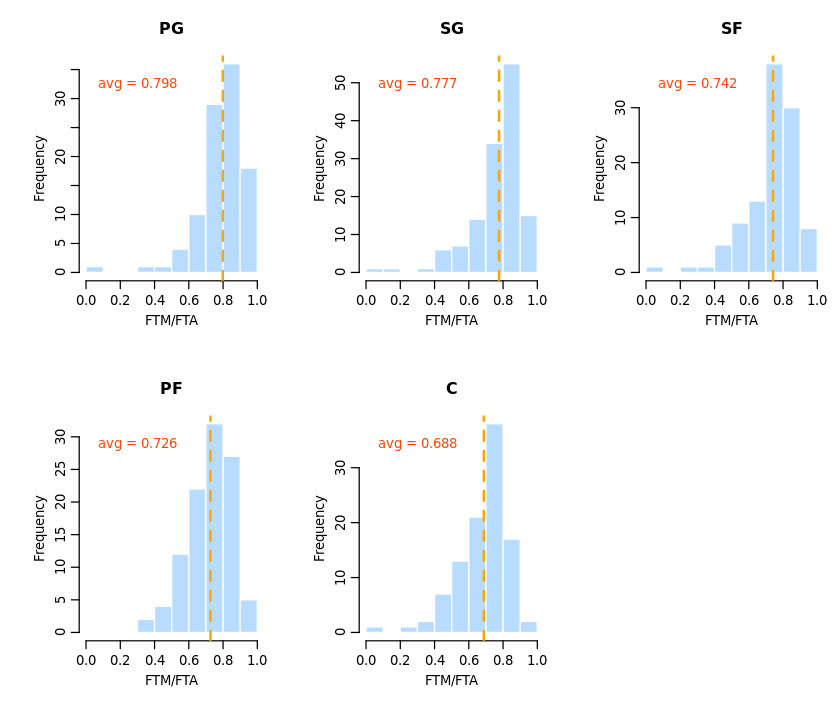

In [ ]:
#FTs shooting percentages for different roles
options(repr.plot.width=7, repr.plot.height=6)
par(mfrow=c(2,3))
par(mar=c(5,5,3.5,1), mgp=c(2.0,0.7,0))
orangeb <- '#ffb47e'

for (p in c('PG', 'SG', 'SF', 'PF', 'C')) {

    h <- hist(players[players$Pos==p,]$'FT%', main=p, xlab='FTM/FTA', xlim=c(0,1), col='#b8dcff', border='white' )
    abline(v=mean(players[players$Pos==p,]$'FT%'), col='orange',lwd=2, lty=2)
    text(0.3,0.9*max(h$counts),paste('avg =', round(mean(players[players$Pos==p,]$'FT%'),3)), col='orangered')
    #text(0.3,0.8*max(h$counts),paste('var =', round(var(players[players$Pos==p,]$'FT%'),3)), col='black')
    
}

The model that will be implemented for our specific case is an **Extended Hierarchical Model** (which stands for an extension to more than 2 dependent parameters of the basic 2 stage Hierarchical Model). \
Thanks to it we'll be able to estimate free throws shooting abilities for individual players, for positions and possibly for the overarching group of all the professional players of the NBA. \
In our schema the **subject $s$** is the label of the single player and the **categories $c$** are the 5 different roles of basketball.

The joint multiparameter posterior of our model will be: 

$$
P(\theta_{s|c},\omega_{c}, k_{c}, \omega_{o}, k_{o}|D) = \frac
    {
    P(D|\theta_{s|c}) P(\theta_{s|c}|\omega_{c},k_{c}) P(k_{c}) P(\omega_{c}|\omega_{o},k_{o})
    P(\omega_{o}) P(k_{o})
    }
    {
    P(D)
    }
$$

The diagram below depicts the structure of our model, from bottom to the top:  

- $y_{i|s,c}$ ~ Bern($\theta_{s|c}$): results of single free throw shot for each player $s$ with role $c$ come from a Bernoulli distribution with probability of single success $\theta_{s|c}$; Binom(N, $\theta_{s|c}$) for N free throws attempts --> $P(D|\theta_{s|c})$ (likelihood)
- $\theta_{s|c}$  ~ Beta($\omega_{c}$, $k_{c}$): probabilities of success of each single player $s$ are sampled from the Beta distribution of the corresponding role $c$ with parameters $\omega_{c}$, $k_{c}$ --> $P(\theta_{s|c}|\omega_{c},k_{c})$ (prior of $\theta_{s|c}$)
- $k_{c}$ ~ Gamma($S_k$, $R_k$): parameters $k_{c}$ for each role $c$ are sampled from a Gamma distribution with parameters $S_k$, $R_k$ fixed for each role  --> $P(k_{c})$ (hyperprior of $k_{c}$)
- $\omega_{c}$ ~ Beta($\omega_{o}$, $k_{o}$): parameters $\omega_{c}$ of each role $c$ are sampled from the overall Beta distribution with parameters $\omega_{o}$, $k_{o}$ --> $P(\omega_{c}|\omega_{o},k_{o})$ (hyperprior of the parameters $\omega_{c}$)
- $\omega_{o}$ ~ Beta($A_{\omega}$, $B_{\omega}$): parameter $\omega_{o}$ comes from a Beta distribution with fixed parameters $A_{\omega}$, $B_{\omega}$ --> $P(\omega_{o})$ (hyper-hyperprior of the overall parameter $\omega_{o}$)
- $k_{o}$ ~ Gamma($S_{k}$, $R_{k}$): parameter $k_{o}$ comes from a Gamma distribution with fixed parameters $S_{k}$, $R_{k}$ --> $P(k_{o})$ (hyper-hyperprior of the overall parameter $k_{o}$)

(In a Beta distribution: \
$\omega$ is the mode, i.e. the higher value of distribution; \
$k$ is the concentration, i.e. how much "the distribution is peaked around the mode")

![](BH_model.png)


## MCMC sampling with JAGS
Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. The idea behid them is to generate a chain that has the desired distribution as its equilibrium distribution, in order to sample from the distribution by recording states from the chain.
One of the possible MCMC methods is the Gibbs sampling, in particular we are using **JAGS** (Just Another Gibbs Sampler), a program that allows analysis of Bayesian hierarchical models.

### Model implementation
Once we have implemented the hierarchical diagram of our model (the one reported in the section "Free Throws Hierarchical Model"), we can look at it to implement the same model in JAGS. The arrows in that diagram indicate the dependencies between the variables, thus every arrow in the hierarchical diagram has a corresponding expression in the JAGS model specification.

$$
P(\theta_{s|c},\omega_{c}, k_{c}, \omega_{o}, k_{o}|D) = \frac
    {
    P(D|\theta_{s|c}) P(\theta_{s|c}|\omega_{c},k_{c}) P(k_{c}) P(\omega_{c}|\omega_{o},k_{o})
    P(\omega_{o}) P(k_{o})
    }
    {
    P(D)
    }
$$

The JAGS model is written directly into a text file, defining the joint posterior of the model introduced before:

In [ ]:
theModel <- function(filename) {

    #model defined as a string
    modelString = "
        model {

        for (sIdx in 1:Nsubj) { #for each player

            #Binomial likelihood for z
            z[sIdx] ~ dbin(theta[sIdx], N[sIdx]) 
            
            #Beta prior for theta 
            theta[sIdx] ~ dbeta(omega[c[sIdx]]*(kappa[c[sIdx]]-2)+1, 
                                (1-omega[c[sIdx]])*(kappa[c[sIdx]]-2)+1)
                                
        }

        for (cIdx in 1:Ncat) { # for each category

            #Beta hyperprior for omega_c
            omega[cIdx] ~ dbeta(omegaO*(kappaO-2)+1, 
                                (1-omegaO)*(kappaO-2)+1)

            #Gamma hyperprior for kappa_c
            kappa[cIdx] <- kappaMinusTwo[cIdx] + 2
            kappaMinusTwo[cIdx] ~ dgamma(0.01, 0.01) #mean=1, var=10 

        }

        #Uniform hyper-hyperprior for omega_O overall
        omegaO ~ dbeta(1.0, 1.0)  

        #Gamma hyper-hyperprior for kappa_O overall 
        kappaO <- kappaMinusTwoO + 2 
        kappaMinusTwoO ~ dgamma(0.01, 0.01)  #mean=1, var=10 

        }"

    #write the string on a text file
    writeLines(modelString, con=filename)

}

In [ ]:
theModel("model.txt")

### Data

Changing dataframe in list to work properly with JAGS.

In [ ]:
theData <- function(data, zName, NName, sName, cName) {

    z <- data[[zName]] #number of made free throws (successes)
    N <- data[[NName]] #number of attempted free throws (trials)
    s <- data[[sName]] #player identifier (subject)
    c <- data[[cName]] #role identifier (category)
    Nsubj <- length(unique(s)) #number of players
    Ncat <- length(unique(c)) #number of roles

    #c is converted to a factor for later conversion in numeric type:
    #1=PG, 2=SG, 3=SF, 4=PF, 5=C 
    c.factor <- factor(c, levels=c("PG", "SG", "SF", "PF", "C"))

    #data in a list for later use in JAGS
    dataList <- list(z=z , N=N , c=as.numeric(c.factor), Nsubj=Nsubj, Ncat=Ncat)

    return(dataList)
}

In [ ]:
playersData <- theData(players, 'FTM', 'FTA', 'Player', 'Pos')

### Chains initialization
Initial values of MCMC chains based on data

In [ ]:
initChains <- function(data) {

    #theta initialization
    thetaInit <- rep(NA,data$Nsubj)
    #sample the initial theta for each subject
    for (sIdx in 1:data$Nsubj) {
        zResampled <- rbinom(1, size=data$N[sIdx], prob=data$z[sIdx]/data$N[sIdx])
        thetaInit[sIdx] <- zResampled/data$N[sIdx] 
    }
    #avoid 0 or 1 initializations
    thetaInit <- 0.001 + 0.998*thetaInit
    
    #lazy initialization for kappa
    kappaInit <- 80

    return(list(theta=thetaInit,
                #Omega_c initialized on mean of thetaInit by category
                omega=aggregate(thetaInit, by=list(data$c), FUN=mean)$x, 
                omegaO=mean(thetaInit),
                kappaMinusTwo=rep(kappaInit-2,data$Ncat),
                kappaMinusTwoO=kappaInit-2))

}

In [ ]:
initValues <- initChains(playersData)

### Sampling
We are now able to run the Markov chains by using the function `runChains`, containing the JAGS function responsible for initializing the model, burning-in the chains and finally sampling.

The parameters this model is going to sample are:
- 6 $k$, 1 $k_c$ for each position + 1 $k_o$ overall
- 6 $\omega$, 1 $\omega_c$ for each position + 1 $\omega_o$ overall
- 546 $\theta_{s|c}$, one for each player

In [ ]:
#install.packages("rjags", configure.args="--enable-rpath")
library("rjags")

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



In [ ]:
runChains <- function(data, inits, saveName=NULL, 
                      numSteps=50000, thinSteps=1, nChains=3) {

    parameters <- c("theta", "omega", "kappa", "omegaO", "kappaO") 
    adaptSteps <- 500 #number of steps to adapt the samplers
    burnInSteps <- 500 #number of steps to burn-in the chains

    #create, initialize, and adapt the model
    cat("Building, initializing and adapting the model\n")
    jagsModel <- jags.model("model.txt", 
                            data=data,
                            inits=inits, 
                            n.chains=nChains,
                            n.adapt=adaptSteps)

    #burn-in of initial samples
    cat("Burning in the MCMC chain\n")
    update(jagsModel, n.iter=burnInSteps)

    #sample the chain
    cat("Sampling final MCMC chain\n")
    MCMCsamples <- coda.samples(jagsModel, variable.names=parameters, 
                               n.iter=ceiling(numSteps*thinSteps/nChains), 
                               thin=thinSteps)  
    
    #save the coda.samples object
    #MCMCSamples[[ chainIdx ]][ stepIdx , paramIdx ]
    if (!is.null(saveName)) {
        save(MCMCsamples, file=paste(saveName,"Mcmc.Rdata",sep=""))
    }

    return(MCMCsamples)
}

In [ ]:
#startTime = proc.time()
#MCMCsamples <- runChains(data=playersData, inits=initValues,
#                         saveName="run2", numSteps=10000, thinSteps=100)
#stopTime = proc.time()
#elapsedTime = stopTime - startTime
#print(elapsedTime)

### Chains analysis

Diagnostics of the chains, returning traceplot, autocorrelation plot and density plot for the desired parameters.

In [ ]:
#load the chains from a Rdata file
load('run1Mcmc.Rdata')
#MCMCsamples <- codaSamples

In [ ]:
#get summary of the sampled chains
#print(summary(MCMCsamples))

In [ ]:
analyzeChains <- function(codaSamples, ind_chain, indices) {

    par(mfrow=c(length(indices), 3))

    for (i in indices) {
        options(repr.plot.width=7, repr.plot.height=6)
        par(mar=c(5,5,3.5,1), mgp=c(2.0,0.7,0))

        #trace plots for all chains
        traceplot(codaSamples[][,i], col=c('darkred','darkorange',orangeb), ylab="Value")

        #autocorrelation plots for the selected chain
        autocorr.plot(codaSamples[ind_chain][,i],col='darkorange', auto.layout=FALSE,
                      main=varnames(codaSamples)[i], cex=2, lwd=3)
    
        #density plots
        densplot(codaSamples[][,i], col=orangeb, lwd=2, ylab='Density', xlab='Value')

    }
}

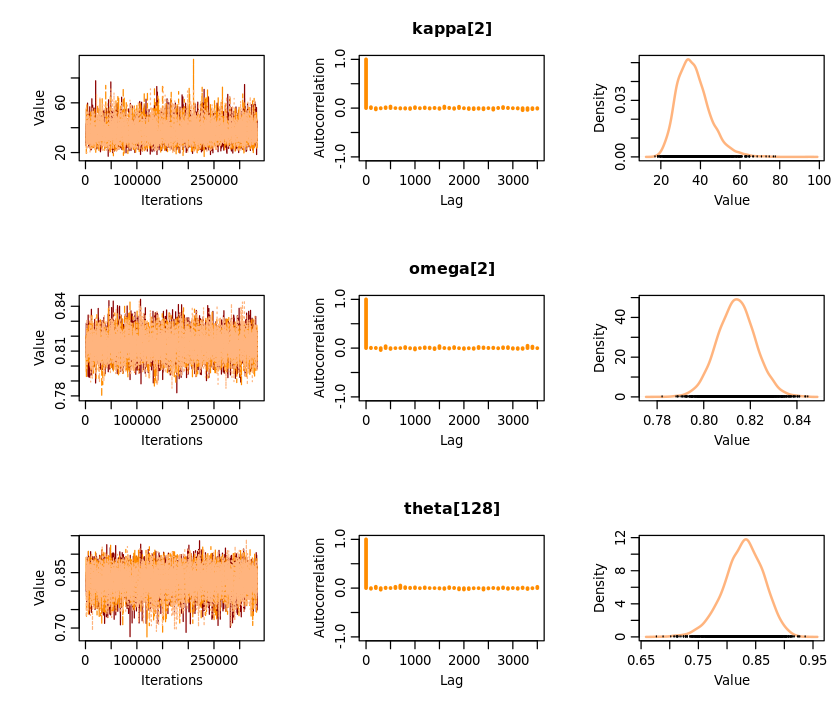

In [ ]:
analyzeChains(MCMCsamples, 2, c(2,8,140))

## Results

### MCMC summaries

The function `summarizePost` below is used to compute mean and credible interval for some chains inside `smryMCMC` and `diffMCMC`, which are further called respectively inside the `parPlotMCMC` and `diffPlotMCMC` plot functions.

In [ ]:
summarizePost <- function(paramSampleVec, ciPct=0.95) {

    #mean
    meanParam <- mean(paramSampleVec)

    #median
    medianParam <- median(paramSampleVec)

    #mode
    dres <- density(paramSampleVec)
    modeParam <- dres$x[which.max(dres$y)]

    #credible interval
    ciParam <- quantile(paramSampleVec, probs=c((1-ciPct)/2, (1+ciPct)/2), names=FALSE)

    return(c(Mean=meanParam, Median=medianParam, Mode=modeParam, CI=ciParam))

}

In [ ]:
smryMCMC <- function(codaSamples) {

    #object containing the chains is converted to a matrix                   
    mcmcMat <- as.matrix(codaSamples, chains=TRUE)

    params <- c('omega', 'kappa', 'theta') #sampled parameters
    summaryInfo <- NULL #empty matrix
    rowIdx <- 0


    for (par in params) {

        #compute diagnostics for each one of the sampled parameters
        for (parName in grep(par, colnames(mcmcMat), value=TRUE)) {
            summaryInfo <- rbind(summaryInfo, summarizePost(mcmcMat[ ,parName]))
            rowIdx <- rowIdx + 1
            rownames(summaryInfo)[rowIdx] <- parName
        }

    }

    return(summaryInfo)

}

In [ ]:
summaryInfo = smryMCMC(MCMCsamples)
head(summaryInfo, 15)

,Mean,Median,Mode,CI1,CI2
omega[1],0.8206065,0.8203047,0.8187871,0.7998748,0.8425212
omega[2],0.8140848,0.8140653,0.8140416,0.7981477,0.8304709
omega[3],0.7733961,0.7732953,0.7729443,0.7529246,0.7943265
omega[4],0.7644102,0.7642383,0.7616894,0.7416353,0.7874749
omega[5],0.7189596,0.7188373,0.7185496,0.6951087,0.7435966
omegaO,0.7403278,0.7832036,0.7872173,0.1446302,0.9116452
kappa[1],27.3012852,26.5530969,24.7727275,17.0837434,41.9183893
kappa[2],36.5608963,35.6803829,33.6567592,23.4084299,55.3551987
kappa[3],33.6469598,32.7028944,30.6780998,20.8317660,51.9109381
kappa[4],23.4816218,23.1023678,22.6475207,15.5769471,33.7360847


In [ ]:
diffMCMC <- function(codaSamples, diffSVec=NULL, diffCVec=NULL) {

    #object containing the chains is converted to a matrix                            
    mcmcMat <- as.matrix(codaSamples,chains=TRUE)

    summaryInfo <- NULL #empty matrix
    rowIdx <- 0

    #differences of theta (players)
    if (!is.null(diffSVec)) {
        Nidx <- length(diffSVec)
        for (t1Idx in 1:(Nidx-1)) {
            for (t2Idx in (t1Idx+1):Nidx) {
                parName1 <- paste0("theta[", diffSVec[t1Idx], "]")
                parName2 <- paste0("theta[", diffSVec[t2Idx], "]")
                summaryInfo <- rbind(summaryInfo, 
                                    summarizePost(mcmcMat[ ,parName1] - mcmcMat[ ,parName2]) )
                rowIdx <- rowIdx + 1
                rownames(summaryInfo)[rowIdx] <- paste0(parName1, "-", parName2)
            }
        }
    }
    
    #differences of omega (roles)
    if (!is.null(diffCVec)) {
        Nidx <- length(diffCVec)
        for (t1Idx in 1:(Nidx-1)) {
            for (t2Idx in (t1Idx+1):Nidx) {
                parName1 <- paste0("omega[", diffCVec[t1Idx], "]")
                parName2 <- paste0("omega[", diffCVec[t2Idx], "]")
                summaryInfo <- rbind(summaryInfo, 
                                    summarizePost(mcmcMat[ ,parName1] - mcmcMat[ ,parName2]) )
                rowIdx <- rowIdx + 1
                rownames(summaryInfo)[rowIdx] <- paste0(parName1, "-", parName2)
            }
        }
    }

    return(summaryInfo)

}

In [ ]:
diffInfo <- diffMCMC(MCMCsamples, diffSVec=c(75, 159), diffCVec=c(2, 3))
diffInfo

,Mean,Median,Mode,CI1,CI2
theta[75]-theta[159],0.05396712,0.05289083,0.05242049,-0.10597359,0.21917416
omega[2]-omega[3],0.04068875,0.04084124,0.04226003,0.01378647,0.06671616


In the following analyses and plots we'll focus on 2 different types of investigations, linked to what we've mentioned in the Introduction:
1) Comparison of the free throws shooting abilities between small players (PGs/SGs) and big men (PFs/Centers)  --> comparison of the inferenced distributions (with MCMC sampling) for the $\omega_{c}$ between small and big players 
2) Analysis of single players, limiting cases of players with a FT% of 0 or 1 (or close to that values) --> comparison between the results of a frequentist and Bayesian (Hierarchical) approach


### Comparison between small and big players

In [ ]:
parPlotMCMC <- function(codaSamples, parName) {

    #get info on the chains summary
    smry <- smryMCMC(codaSamples)

    #conversion to matrix
    mcmcMat <- as.matrix(codaSamples, chains=TRUE)

    #plot settings
    options(repr.plot.width=8, repr.plot.height=6)
    par(mfrow=c(2,3))
    par(mar=c(4,4,2,0.1), mgp=c(2.0,0.7,0))
    
    #names and indices
    parNames <- grep(parName, colnames(mcmcMat), value=TRUE)
    mainLab <- c("PG", "SG", "SF", "PF", "C","Overall")
    mainIdx <- 0

    #plot
    for (i in parNames) {

        #posterior histograms
        mainIdx <- mainIdx + 1
        h <- hist(mcmcMat[ ,i],
            xlab=bquote(.(i)), cex.lab=1.25, 
            main=mainLab[mainIdx], cex.main=1.5,
            xlim=c(smry[i, 'CI1']-0.05, smry[i, 'CI2']+0.05), col=orangeb,
            border="white")

        #mean and 95% ci
        abline(v=smry[i, 'Mean'], col="navy", lwd=2, lty=2)
        abline(v=c(smry[i, 'CI1'], smry[i, 'CI2']), col="red", lwd=1, lty=2)
        
        #legend
        legend('topleft', bty='n', text.col='navy', cex=1.1,
                legend=paste('mean\n',round(smry[i, 'Mean'],3)))

    }

}

First, we plot the histograms of the sampled values for the parameters $\omega_c$ with $c$ from 1 to 5 (corresponding to the 5 different basketball-roles). They correspond to the representation of the obtained marginalized posteriors for each of the $\omega_{c}$. 

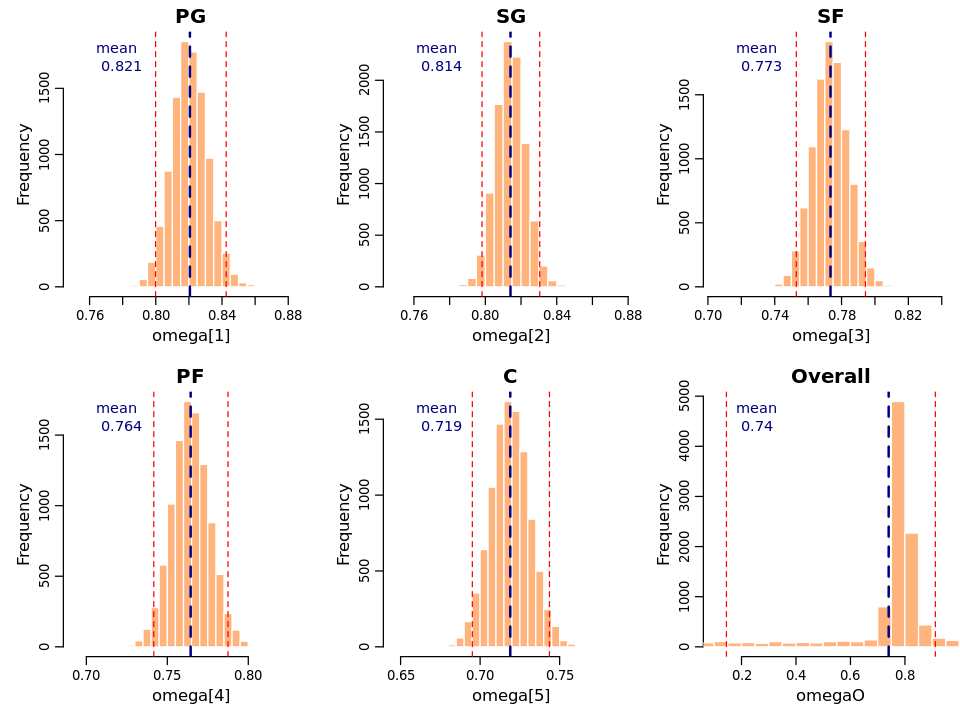

In [ ]:
parPlotMCMC(MCMCsamples, "omega")

In [ ]:
diffPlotMCMC <- function(codaSamples, data, parName, diffSList=NULL, diffCList=NULL) {

    #get info on the chains summary and differences
    smry <- smryMCMC(codaSamples)
    diff <- diffMCMC(codaSamples, diffSVec=diffSList, diffCVec=diffCList)

    #conversion to matrix
    mcmcMat <- as.matrix(codaSamples, chains=TRUE)

    #plot settings
    options(repr.plot.width=7, repr.plot.height=6)
    par(mfrow=c(2,2))
    par(mar=c(5,3,4,1), mgp=c(2.0,0.7,0))
    
    #names and indices
    if (parName=='omega') {
        parNames <- grep(parName, colnames(mcmcMat), value=TRUE)[diffCList]
        mainLab <- c("PG", "SG", "SF", "PF", "C", "Overall")[diffCList]
        }
    if (parName=='theta') {
        parNames <- grep(parName, colnames(mcmcMat), value=TRUE)[diffSList]
        mainLab <- c(paste0(data$Player[diffSList[1]],'(',data$Pos[diffSList[1]],')'), paste0(data$Player[diffSList[2]],'(',data$Pos[diffSList[2]],')'))
        }
    mainIdx <- 0

    #omega/theta posterior histogram for single role/player
    for (i in parNames) {
        mainIdx <- mainIdx + 1
        hist(mcmcMat[ ,i],
            xlab=bquote(.(i)), cex.lab=1.25, 
            main=mainLab[mainIdx],
            cex.main=1,
            xlim=quantile(mcmcMat[ ,parNames], probs=c(0.000,0.995)), border="white", col=orangeb)
        abline(v=c(smry[i, 'CI1'], smry[i, 'CI2']), col="red", lwd=1, lty=2)
        abline(v=smry[i, 'Mean'], col="navy", lwd=2, lty=2)
        meanLeg <- paste0('mean = ',round(smry[i, 'Mean'],3))
        ciLeg <- paste0('CI = [',round(smry[i, 'CI1'],3),',',round(smry[i, 'CI2'],3),']')
        legend('topleft', inset=c(-0.05,-0.15), bty='n', text.col=c('navy','red'), cex=0.9,
                legend=c(meanLeg, ciLeg), xpd=TRUE, horiz=TRUE)
    }

    #posterior histogram for difference of omega/theta for roles/players
    hist(mcmcMat[ ,parNames[1]] - mcmcMat[ ,parNames[2]],
        xlab=paste0(parName, ' diff'), cex.lab=1.25, 
        main=paste0(mainLab[1],'-',mainLab[2]), cex.main=1, border="white",
        xlim=quantile(mcmcMat[ ,parNames[1]] - mcmcMat[ ,parNames[2]], probs=c(0.000,0.995)),col=orangeb)
    if (parName=='omega') {
        abline(v=diff[2, 'Mean'], col="navy", lwd=2, lty=2)
        abline(v=c(diff[2, 'CI1'], diff[2, 'CI2']), col="red", lwd=1, lty=2)
        meanLeg <- paste0('mean = ',round(diff[2, 'Mean'],3))
        ciLeg <- paste0('CI = [',round(diff[2, 'CI1'],3),',',round(diff[2, 'CI2'],3),']')
    }
    if (parName=='theta') {
        abline(v=diff[1, 'Mean'], col="navy", lwd=2, lty=2)
        abline(v=c(diff[1, 'CI1'], diff[1, 'CI2']), col="red", lwd=1, lty=2)
        meanLeg <- paste0('mean = ', round(diff[1, 'Mean'],3))
        ciLeg <- paste0('CI = [',round(diff[1, 'CI1'],3),',',round(diff[1, 'CI2'],3),']')
    }
    legend('topleft', inset=c(-0.05,-0.15), bty='n', text.col=c('navy','red'), cex=0.9,
        legend=c(meanLeg,ciLeg), xpd=TRUE, horiz=TRUE)

    #correlation plot
    if (parName=='omega') {title <- paste0(mainLab[1], ' vs ', mainLab[2])}
    if (parName=='theta') {title <- paste0(mainLab[1], '\n vs \n', mainLab[2])}
    plot(mcmcMat[,parNames[1]], mcmcMat[,parNames[2]],
        xlab=mainLab[1], ylab=mainLab[2], cex.lab=1.25,
        main=title, cex.main=1, pch=21,
        bg=orangeb, col='black', cex=0.8)
            
}

Then we look directly to the histograms of the differences between small players and big players.\
Firstly, we analyse the two most distant roles in term of size which are **PGs** and **Centers**; \
then we analyse the difference between **SGs** and **PFs**, which are the closest ones (within the differentiation between small and big players). 

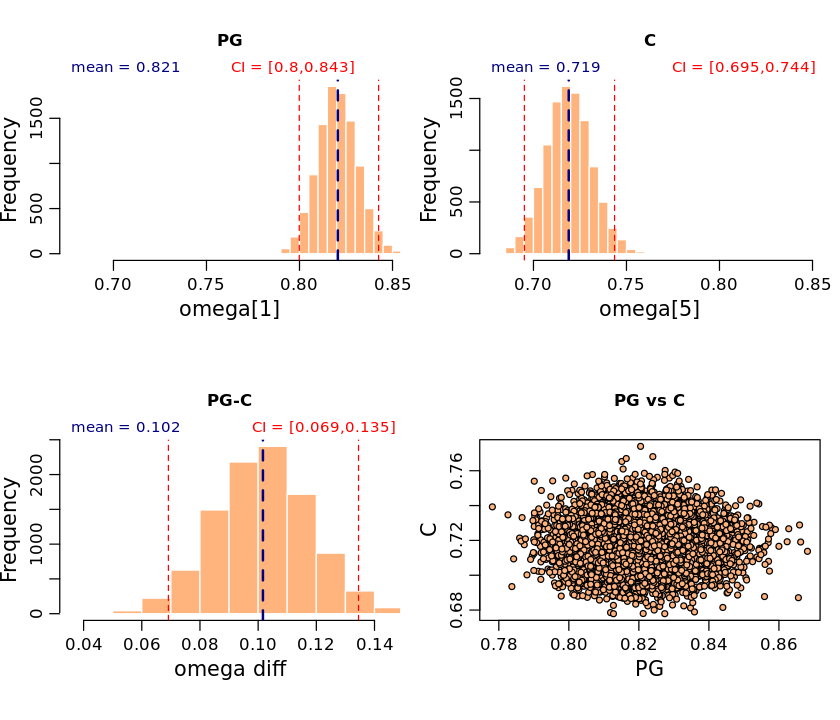

In [ ]:
diffPlotMCMC(MCMCsamples, players, "omega", diffSList=c(444,111), diffCList=c(1,5))

**Hypothesis test:**

1) **PG vs C**
$H_0$ (Null hypothesis):    $\omega_{diff(PG-C)}$ = 0

We can **reject** the null-hypothesis at the 5% level of significance (C.I.=95\%), since the value of 0 for $\omega_{diff(PG-C)}$ lies outside the computed 95% Credible Interval.

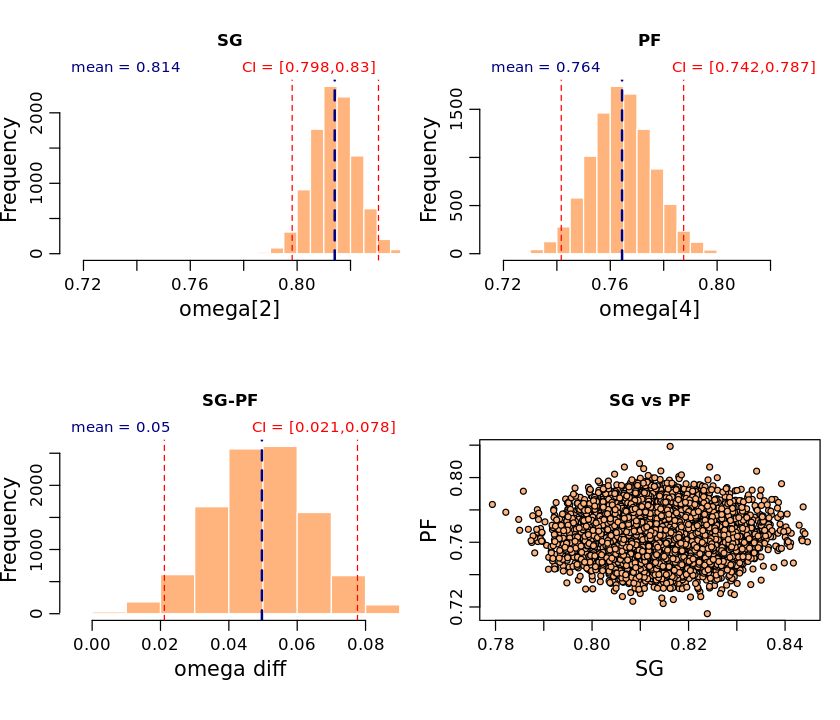

In [ ]:
diffPlotMCMC(MCMCsamples, players, "omega", diffSList=c(444,111), diffCList=c(2,4))

**Hypothesis test**

2) **SG vs PF**
$H_0$ (Null hypothesis):    $\omega_{diff(SG-PF)}$ = 0

We can **reject** the null-hypothesis with a 5% level of significance (C.I.=95\%), since the value of 0 for $\omega_{diff(SG-PF)}$ lies outside the computed 95% Credible Interval.

In both the comparisons conducted we've reached the conclusion that actually there is a significant difference in the $\omega_{c}$'s estimated (modes of the $\theta$'s distributions) between small and big players. \
This trend is such that it leads to a mean value of more than 0.10 in the $\omega_{1}-\omega_{5}$ distribution (difference between the smallest (PGs) and biggest (Centers) players $\omega$'s). 

These results are coherent with our preassumption (explicated in the Introduction).

### Analysis of limiting cases: frequentist vs Bayesian

In order to analyse the kind of limiting cases mentioned before we start by looking at the comparison between two players (**Stephen Curry** and **Jabari Parker**) with an extremely high FT\% datum (92.3\% and 100\%), but a huge difference in the number of FT attempts (298 and 9) collected during the 2021-2022 Regular Season.

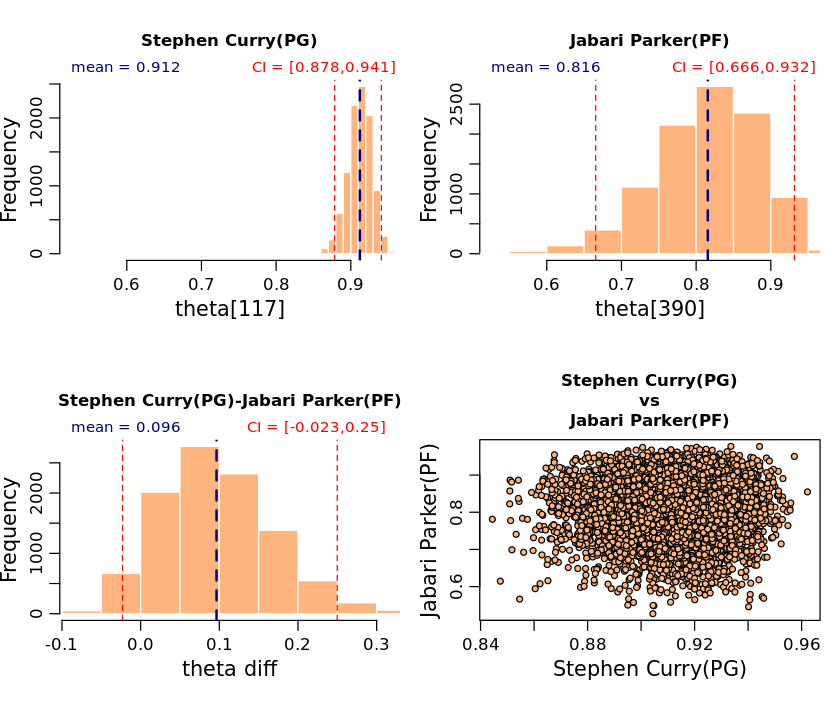

In [ ]:
diffPlotMCMC(MCMCsamples, players, "theta", diffSList=c(117,390), diffCList=c(1,5))

**Hypothesis test (Curry vs Parker)**

$H_0$ (Null hypothesis): $\theta_{diff(Curry-Parker)}$ = 0

- We can **not reject** the null-hypothesis at the 5% level of significance (C.I.=95\%)
- We can **reject** the null-hypothesis at the 15% level of significance (C.I.=85\%)

In [ ]:
library('mcmcplots')

In [ ]:
Freq_vs_Bayes <- function(data, codaSamples, indices) {

    #names of players
    playerNames <- c(data$Player[indices])

    #bayesian
    mcmcMat = as.matrix(codaSamples,chains=TRUE)
    parNames = grep("theta", colnames(mcmcMat), value=TRUE)[indices]
    options(repr.plot.width=6, repr.plot.height=7)
    par(mar=c(5,7,3,1), mgp=c(2.0,0.7,0))
    caterplot(codaSamples, parms=parNames, labels=playerNames, reorder=F, collapse=T, denstrip=F,
             lwd=c(1,2), pch=16, style='gray', col='cornflowerblue', cex.axis=0.2,
             xlab='theta estimation', val.lim=c(0,1))

    #frequentist
    caterpoints(data$'FT%'[indices], col='darkorange', lwd=1.5)

    #legend
    legend("top", inset=c(0, -0.08), bty='n', lty=c(1,0), pch=c(16,1), lwd=c(1,1.5),
            legend=c('Bayesian', 'Frequentist'), col=c('cornflowerblue', 'darkorange'), xpd=TRUE, horiz=TRUE)

}

Now we look to the comparison in the estimation of single-player's $\theta$ (probability of success in a free throw attempt) in some meaningful cases (included the Curry and Parker's cases mentioned before) which can be performed with a **frequentist** approach and with the **Bayesian (Hierarchical)** approach implemented in our analysis.

In [ ]:
#shooting percentage of some selected players
playersIdx <- c(28, 53, 89, 129, 147, 5, 422, 165, 117, 390, 415)
players[playersIdx,]

,Player,Pos,FTM,FTA,FT%
,<chr>,<chr>,<int>,<int>,<dbl>
38,Cat Barber,PG,0,4,0.000
68,Bol Bol,PF,2,5,0.400
113,Clint Capela,C,80,169,0.473
179,Luka Dončić,PG,364,489,0.744
207,Joel Embiid,C,654,803,0.814
5,LaMarcus Aldridge,C,89,102,0.873
620,Cam Reddish,SF,101,112,0.902
243,Danilo Gallinari,PF,141,156,0.904
160,Stephen Curry,PG,275,298,0.923


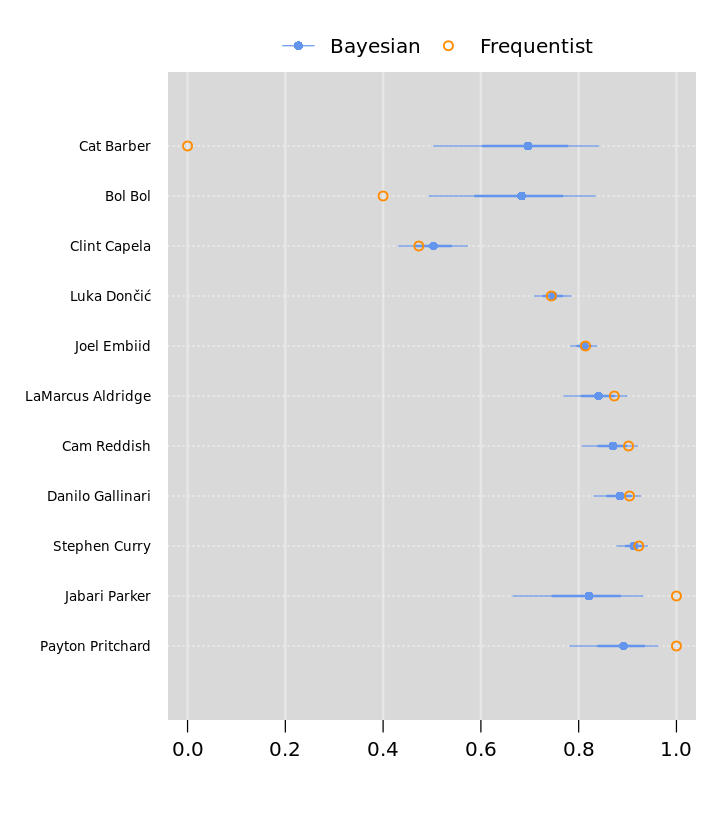

In [ ]:
Freq_vs_Bayes(players, MCMCsamples, playersIdx)

By looking at these comparisons we can clearly observe a few things:

- the Bayesian approach leads to more realistic estimation of $\theta$ for the players with limiting cases of the FT\% collected in the 2021-2022 Regular Season, in comparison with the biased estimation that the frequentist approach allows to reach (due to the too little number of available data)   (e.g. **Barber**, **Bol** (~ 0 FTM/FTA); **Parker**, **Pritchard** (1 FTM/FTA));
- in the case in which (vice-versa) there are many data available for a certain player (which means that this specific player attempted a large number of three throw during the 2021-2022 season) the Bayesian and the frequetist estimation of $\theta$ tends to converge, in accordance with the known fact that, in general, the Bayesian posterior tends to be more independent from the prior (and hyperpriors in the Hierarchical context) choices as the data available for the estimation of the parameter start to be significatively large   (e.g. **Dončić**, comparison between **Bol** and **Capela**,  **Embiid**);
- thanks to the Hierarchical structure of our Bayesian model, the estimations of the $\theta$ parameters of the single players are dependent on the player's role too and this can be seen more clearly in the cases of players who have totalized during the 2021-2022 Reg.Season a FT\% significatively distant from their role mean even in case of quite large number of FTA (e.g. **Aldridge(C)**, **Reddish(SF)**, **Gallinari(PF)** (**Curry(PG)**) ).  

## References
Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan - John K. Kruschke

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e8635fd6-54d9-4baa-93a3-46a88833cc83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>